In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.under_sampling import NearMiss
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [3]:
df = pd.read_excel("./energy_demand.xlsx")
df.head()

Date    2014-12-31 00:00:00
Hour                     24
load                 5224.0
T                      95.0
dtype: object

In [4]:
df.tail()

,Date,Hour,load,T
26300,2014-12-31,20,4012.0,18.000000
26301,2014-12-31,21,3856.0,16.666667
26302,2014-12-31,22,3671.0,17.000000
26303,2014-12-31,23,3499.0,15.333333
26304,2014-12-31,24,3345.0,15.333333


In [5]:
len(df.columns)

4

In [6]:
df.columns
df.dtypes

Date    datetime64[ns]
Hour             int64
load           float64
T              float64
dtype: object

In [7]:
df.shape

(26305, 4)

In [8]:
df.size

105220

In [9]:
df.min()

Date    2012-01-01 00:00:00
Hour                      0
load                 1979.0
T                -13.666667
dtype: object

In [10]:
df.max()

Date    2014-12-31 00:00:00
Hour                     24
load                 5224.0
T                      95.0
dtype: object

In [11]:
df.describe()

,Date,Hour,load,T
count,26305,26305.000000,26305.000000,26305.000000
mean,2013-07-01 11:30:01.710701312,12.499525,3303.752785,47.764988
min,2012-01-01 00:00:00,0.000000,1979.000000,-13.666667
25%,2012-09-30 00:00:00,6.000000,2867.000000,32.666667
50%,2013-07-01 00:00:00,12.000000,3364.000000,48.333333
75%,2014-04-01 00:00:00,18.000000,3690.000000,63.666667
max,2014-12-31 00:00:00,24.000000,5224.000000,95.000000
std,NaN,6.922616,564.574798,19.338062


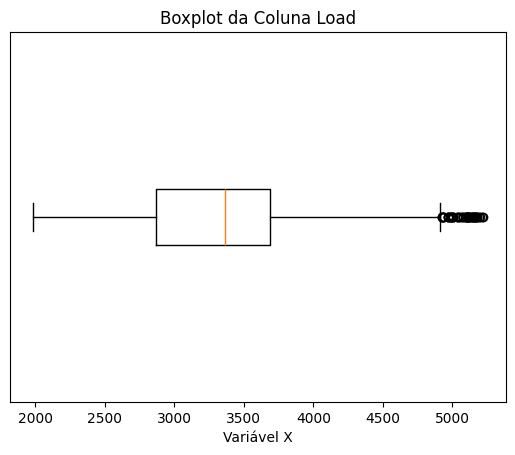

In [18]:
plt.boxplot(df['load'], vert=False)

# Adiciona rótulos e título
plt.xlabel('Variável X')
plt.title('Boxplot da Coluna Load')
plt.yticks([])

# Mostra o boxplot
plt.show()